In [2]:
import pandas as pd
import pymorphy2 as pm
morph = pm.MorphAnalyzer()
import ast
from tqdm import tqdm_notebook

import random
from random import shuffle

import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import xgboost as xgb

In [3]:
matplotlib inline

In [4]:
dftrain, dftest = pd.read_csv("./trainTFIDF.csv"), pd.read_csv("./testTFIDF.csv")

In [6]:
from sklearn.metrics.pairwise import paired_cosine_distances

In [7]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import SnowballStemmer 
from nltk.corpus import stopwords

import string

In [6]:
dftest = dftest.drop_duplicates()
dftrain = dftrain.drop_duplicates()

In [7]:
dftest.shape

(74290, 53)

In [8]:
dftrain.shape

(119398, 52)

In [9]:
pdf=dftest.groupby(['question_id', 'paragraph_id']).agg({'paragraph_id': 'count'})

In [10]:
pdf[pdf['paragraph_id']>1]

,,paragraph_id
question_id,paragraph_id,


## Анализ вопросов в тесте 

In [65]:
questions = dftest.question_id.unique()
nums_list=[]
for i in tqdm_notebook(questions, total=len(questions), desc= ' questions'):
    length = dftest[dftest.question_id==i]['len_question'].values[0]
    qw = dftest[dftest.question_id==i]['qw_question_up'].values[0]
    verb = dftest[dftest.question_id==i]['verb_question_up'].values[0]
    adj = dftest[dftest.question_id==i]['adj_question_up'].values[0]
    noun = dftest[dftest.question_id==i]['noun_question_up'].values[0]
    
    nums_list.append([i, len(ast.literal_eval(qw))/length, 
            len(ast.literal_eval(verb))/length,
            len(ast.literal_eval(adj))/length,
            len(ast.literal_eval(noun))/length])

In [66]:
labels_q = ['question_id', 'qw_num', 'verb_num','adj_num','noun_num']
dfnums = pd.DataFrame.from_records(nums_list, columns=labels_q)
dftest = dftest.merge(dfnums, how = 'left', on=['question_id'])

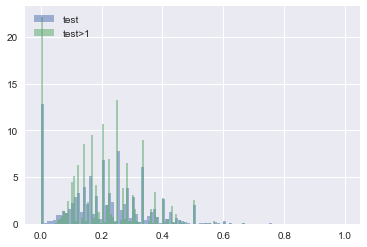

In [23]:
kwargs = dict(alpha=0.5, normed=True, bins=100)
plt.hist(dftest[dftest['count_q']==1]['adj_num'], label = 'test', **kwargs)
plt.hist(dftest[dftest['count_q']>1]['adj_num'], label = 'test>1', **kwargs)
plt.legend(loc='upper left')
plt.show()

#### Частота по вопросам, параграфам 

In [ ]:
test_question = dftest.groupby(['question']).agg({'paragraph_id': 'count'})
test_question = pd.DataFrame({'question': test_question.index, 'count_q': test_question.paragraph_id})
test_question['count_q'] = test_question['count_q'].astype(int)
dftest = dftest.merge(test_question, how = 'left', on='question')

In [ ]:
test_par = dftest.groupby(['paragraph_id']).agg({'question_id': 'count'})
test_par = pd.DataFrame({'paragraph_id': test_par.index, 'count_p': test_par.question_id})
test_par['count_p'] = test_par['count_p'].astype(int)
dftest = dftest.merge(test_par, how = 'left', on='paragraph_id')

In [ ]:
train_question = dftrain.groupby(['question']).agg({'paragraph_id': 'count'})
train_question = pd.DataFrame({'question': train_question.index, 'count_q': train_question.paragraph_id})
train_question['count_q'] = train_question['count_q'].astype(int)
dftrain = dftrain.merge(train_question, how = 'left', on='question')

In [ ]:
train_par = dftrain.groupby(['paragraph_id']).agg({'question_id': 'count'})
train_par = pd.DataFrame({'paragraph_id': train_par.index, 'count_p': train_par.question_id})
train_par['count_p'] = train_par['count_p'].astype(int)
dftrain = dftrain.merge(train_par, how = 'left', on='paragraph_id')

#### TDIDF (по всем параграфам вопроса) 

In [ ]:
questions_test = dftest.question_id.unique()

In [ ]:
questions_train = dftrain.question_id.unique()

In [ ]:
for name, qlist, df in [('train', questions_train, dftrain), ('test', questions_test, dftest)]: 
    pair_list=[]
    best_list=[]
    
    for i in tqdm_notebook(qlist, total=len(qlist), desc= name + ' questions'):
        scores=[]
        par_ids=list(df[df['question_id']==i]['paragraph_id'].unique())
        texts = list(df[df['question_id']==i]['tokens_paragraph_up'].unique())+\
        list(df[df['question_id']==i]['tokens_question_up'].unique())
        #print(texts)
        tfidf = TfidfVectorizer()
        tfidf_matrix=tfidf.fit_transform(texts)
        qvec = tfidf_matrix[len(texts)-1]
        for n, t in enumerate(texts):
            if n!=len(texts)-1:
                par=par_ids[n]
                svec = tfidf_matrix[n]
                score=float(paired_cosine_distances(svec,qvec))
                scores.append(score)
                pair_list.append([i, par, score])
            else:
                pass
        imin=np.argmin(scores)
        best_list.append([i, par_ids[imin], scores[imin]])
               
        
    labels = ['question_id', 'paragraph_id', 'score']
    labels_best = ['question_id', 'best_paragraph', 'best_score']
    dfscores = pd.DataFrame.from_records(pair_list, columns=labels)
    dfbest = pd.DataFrame.from_records(best_list, columns=labels_best)
    if name=='train':
        dftrain = dftrain.merge(dfscores, how = 'left', on=['question_id','paragraph_id'])
        dftrain = dftrain.merge(dfbest, how = 'left', on=['question_id'])
    else:
        dftest = dftest.merge(dfscores, how = 'left', on=['question_id','paragraph_id'])
        dftest = dftest.merge(dfbest, how = 'left', on=['question_id'])

In [ ]:
dftest.shape

In [ ]:
dftrain.shape

# 

In [ ]:
questions_test = dftest.question_id.unique()

In [ ]:
questions_train = dftrain.question_id.unique()

In [ ]:
for name, qlist, df in [('train', questions_train, dftrain), ('test', questions_test, dftest)]: 
    pair_list=[]
    best_list=[]
    
    for i in tqdm_notebook(qlist, total=len(qlist), desc= name + ' questions'):
        scores=[]
        par_ids=list(df[df['question_id']==i]['paragraph_id'].unique())
        texts = list(df[df['question_id']==i]['tokens_paragraph_up'].unique())+\
        list(df[df['question_id']==i]['tokens_question_up'].unique())
        #print(texts)
        tfidf = TfidfVectorizer()
        tfidf_matrix=tfidf.fit_transform(texts)
        qvec = tfidf_matrix[len(texts)-1]
        for n, t in enumerate(texts):
            if n!=len(texts)-1:
                par=par_ids[n]
                svec = tfidf_matrix[n]
                score=float(paired_cosine_distances(svec,qvec))
                scores.append(score)
                pair_list.append([i, par, score])
            else:
                pass
        imin=np.argmin(scores)
        best_list.append([i, par_ids[imin], scores[imin]])
               
        
    labels = ['question_id', 'paragraph_id', 'score']
    labels_best = ['question_id', 'best_paragraph', 'best_score']
    dfscores = pd.DataFrame.from_records(pair_list, columns=labels)
    dfbest = pd.DataFrame.from_records(best_list, columns=labels_best)
    if name=='train':
        dftrain = dftrain.merge(dfscores, how = 'left', on=['question_id','paragraph_id'])
        dftrain = dftrain.merge(dfbest, how = 'left', on=['question_id'])
    else:
        dftest = dftest.merge(dfscores, how = 'left', on=['question_id','paragraph_id'])
        dftest = dftest.merge(dfbest, how = 'left', on=['question_id'])

In [ ]:
dftest.shape

In [ ]:
dftrain.shape

#### TDIDF (по всем вопросам параграфа) 

In [ ]:
par_test = dftest.paragraph_id.unique()
par_train = dftrain.paragraph_id.unique()

In [ ]:
for name, plist, df in [('train', par_train, dftrain), ('test', par_test, dftest)]: 
    pair_list=[]
    best_list=[]
    
    for i in tqdm_notebook(plist, total=len(plist), desc= name + ' paragraphs'):
        scores=[]
        q_ids=list(df[df['paragraph_id']==i]['question_id'].unique())
        texts = list(df[df['paragraph_id']==i]['tokens_question_up'].unique())+\
        list(df[df['paragraph_id']==i]['tokens_paragraph_up'].unique())
        tfidf = TfidfVectorizer()
        tfidf_matrix=tfidf.fit_transform(texts)
        pvec = tfidf_matrix[len(texts)-1]
        for n, t in enumerate(texts):
            if n!=len(texts)-1:
                quest=q_ids[n]
                svec = tfidf_matrix[n]
                score=float(paired_cosine_distances(svec,pvec))
                scores.append(score)
                pair_list.append([i, quest, score])
            else:
                pass
        imin=np.argmin(scores)
        best_list.append([i, q_ids[imin], scores[imin]])
               
        
    labels = ['paragraph_id', 'question_id', 'score1']
    labels_best = ['paragraph_id', 'best_question', 'best_score1']
    dfscores = pd.DataFrame.from_records(pair_list, columns=labels)
    dfbest = pd.DataFrame.from_records(best_list, columns=labels_best)
    if name=='train':
        dftrain = dftrain.merge(dfscores, how = 'left', on=['question_id','paragraph_id'])
        dftrain = dftrain.merge(dfbest, how = 'left', on=['paragraph_id'])
    else:
        dftest = dftest.merge(dfscores, how = 'left', on=['question_id','paragraph_id'])
        dftest = dftest.merge(dfbest, how = 'left', on=['paragraph_id'])

In [ ]:
dftrain = dftrain.fillna(-1)
dftest = dftest.fillna(-1)

In [ ]:
dftrain['dist'] = dftrain['score']-dftrain['best_score']
dftest['dist'] = dftest['score']-dftest['best_score']

In [ ]:
dftrain['dist1'] = dftrain['score1']-dftrain['best_score1']
dftest['dist1'] = dftest['score1']-dftest['best_score1']

In [ ]:
dftest.shape

In [ ]:
dftrain.shape

In [ ]:
#del dftrain['score_x']
#del dftrain['score_y']
#del dftest['score_x']
#del dftest['score_y']

#### Похожесть слов внутри вопроса (word2vec)

In [52]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

/Users/annavozmishcheva/anaconda/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [53]:
model = KeyedVectors.load_word2vec_format('./ruwikiruscorpora_0_300_20.bin', binary=True)

In [54]:
pos = list(['_NOUN', '_ADJ', '_VERB', '_ADV', '_INTJ', '_ADP', '_PART', '_NUM', '_DET', '_PRON'])
for key in tqdm_notebook(model.vocab.keys(), total=len(model.vocab.keys()), desc= ''):
    for p in pos:
        if key.endswith(p):
            repl = key.replace(p,'')
            #print(repl)
    if repl not in model.vocab.keys():
        model.vocab[repl] = model.vocab.pop(key)
    else:
        pass

In [ ]:
for name, df in [('train', dftrain), ('test', dftest)]: 
    for index, row in tqdm_notebook(df.iterrows(), total=df.shape[0], desc= name + ' questions'):
        scores_q=[]
        for i, w in enumerate(ast.literal_eval(df.tokens_question_up.values[index])):
            scores=[]
            if w in model.vocab.keys():
                for j, w2 in enumerate(ast.literal_eval(df.tokens_question_up.values[index])):
                    if (w2 in model.vocab.keys())&(w2!=w):
                        scores.append(model.similarity(w, w2))
            avg_score = np.average(scores)
            scores_q.append(avg_score)
        avg_scores_q = np.average(scores_q)
        df.loc[index, 'w2v_question']=avg_scores_q

In [ ]:
dftrain['w2v_question'].isnull().sum()

In [ ]:
dftest['w2v_question'].isnull().sum()

In [ ]:
dftrain['w2v_question']=dftrain['w2v_question'].fillna(-1)

In [ ]:
dftest['w2v_question']=dftest['w2v_question'].fillna(-1)

In [ ]:
dftest.shape

#### Анализ токенов вопроса, которых нет в параграфе 

In [76]:
for dfname, quest, df in [('train','tokens_question_up', dftrain), 
                         ('test','tokens_question_up', dftest)]:
    for index, row in tqdm_notebook(df.iterrows(), total=df.shape[0], desc= dfname):
        len_q=float(row['len_question'])
        red= [w for w in ast.literal_eval(row[quest]) if w not in ast.literal_eval(row['tokens_paragraph_up'])]
        norm=[w for w in ast.literal_eval(row[quest]) if w in ast.literal_eval(row['tokens_paragraph_up'])]
        ratio=len(red)/len_q
        df.loc[index,'red_ratio']=ratio
        if ratio<1:
            scores_q=[]
            for i, w in enumerate(res):
                scores=[]
                if w in model.vocab.keys():
                    for j, w2 in enumerate(norm):
                        if w2 in model.vocab.keys():
                            scores.append(model.similarity(w, w2))
                    avg_score = np.average(scores)
                    scores_q.append(avg_score)
            avg_scores_q = np.average(scores_q)
            df.loc[index, 'w2v_red']=avg_scores_q

In [66]:
dftrain.red_ratio.values[5]

0.92307692307692313

In [77]:
dftrain['w2v_red'].isnull().sum()

31942

In [78]:
dftest['w2v_red'].isnull().sum()

2926

In [79]:
dftrain['red_ratio'].isnull().sum()

0

In [80]:
dftest['red_ratio'].isnull().sum()

0

In [81]:
dftrain = dftrain.fillna(0)
dftest = dftest.fillna(0)

#### Частота слов в вопросе  

In [ ]:
dftest['frequency']=0.0
dftrain['frequency']=0.0
for dfname, quest, df in [('train','tokens_question_up', dftrain), 
                         ('test','tokens_question_up', dftest)]:
    for index, row in tqdm_notebook(df.iterrows(), total=df.shape[0], desc= dfname):
        len_uniq = len(set(ast.literal_eval(row[quest])))
        len_total = len(ast.literal_eval(row[quest]))
        df.loc[index, 'frequency'] = len_uniq/len_total 

#### Бейзлайн фичи 

In [ ]:
for name, df in [('train', dftrain), ('test', dftest)]:
    for index, row in tqdm_notebook(df.iterrows(), total=df.shape[0], desc="build features for " + name):
        question = ast.literal_eval(df.tokens_question_up.values[index])
        paragraph = ast.literal_eval(df.tokens_paragraph_up[index])
        df.loc[index, 'len_paragraph'] = len(paragraph)
        df.loc[index, 'len_question'] = len(question)
        df.loc[index, 'len_intersection'] = len(set(question) & set(paragraph))

### Описание 

In [ ]:
dftrain.info()

In [ ]:
dftest.info()

## Частота вопросов, ответов

In [ ]:
print('Train:')
print('Повторяющихся вопросов (вопросов, которые задаются нескольким параграфам): ' + str(len(dftrain[dftrain['count_q']>1].question.unique())))
print('Уникальных вопросов (вопросов, которые задаются только одному параграфу): ' + str(dftrain[dftrain['count_q']==1].question.count()))
print('Всего уникальных параграфов: ' + str(len(dftrain.paragraph.unique())))
print('Параграфов, к которым задаются повторяющиеся вопросы: ' + str(len(dftrain[dftrain['count_q']>1].paragraph.unique())))
print('Параграфов, к которым задаются уникальные вопросы: ' + str(len(dftrain[dftrain['count_q']==1].paragraph.unique())))
print()
print('Test:')
print('Повторяющихся вопросов (вопросов, которые задаются нескольким параграфам): ' + str(len(dftest[dftest['count_q']>1].question.unique())))
print('Уникальных вопросов (вопросов, которые задаются только одному параграфу): ' + str(dftest[dftest['count_q']==1].question.count()))
print('Всего уникальных параграфов: ' + str(len(dftest.paragraph.unique())))
print('Параграфов, к которым задаются повторяющиеся вопросы: ' + str(len(dftest[dftest['count_q']>1].paragraph.unique())))
print('Параграфов, к которым задаются уникальные вопросы: ' + str(len(dftest[dftest['count_q']==1].paragraph.unique())))

In [ ]:
print('Train:')
print('Повторяющихся параграфов (параграфов, к которым задаются несколько вопросов): ' + str(len(dftrain[dftrain['count_p']>1].paragraph.unique())))
print('Уникальных параграфов (параграфов, к которым задается один вопрос): ' + str(dftrain[dftrain['count_p']==1].paragraph.count()))
print('Всего уникальных вопросов: ' + str(len(dftrain.question.unique())))
print('Вопросов, которые задаются повторяющимся параграфам: ' + str(len(dftrain[dftrain['count_p']>1].question.unique())))
print('Вопросов, которые задаются уникальным параграфам: ' + str(len(dftrain[dftrain['count_p']==1].question.unique())))
print()
print('Test:')
print('Повторяющихся параграфов (параграфов, к которым задаются несколько вопросов): ' + str(len(dftest[dftest['count_p']>1].paragraph.unique())))
print('Уникальных параграфов (параграфов, к которым задается один вопрос): ' + str(dftest[dftest['count_p']==1].paragraph.count()))
print('Всего уникальных вопросов: ' + str(len(dftest.question.unique())))
print('Вопросов, которые задаются повторяющимся параграфам: ' + str(len(dftest[dftest['count_p']>1].question.unique())))
print('Вопросов, которые задаются уникальным параграфам: ' + str(len(dftest[dftest['count_p']==1].question.unique())))

In [ ]:
kwargs = dict(alpha=0.5, normed=True, bins=50)
plt.hist(dftest[dftest['count_q']==1]['count_p'], label = 'test', **kwargs)
plt.hist(dftest[dftest['count_q']>1]['count_p'], label = 'test>1', **kwargs)
plt.legend(loc='upper left')
plt.show()

In [ ]:
kwargs = dict(alpha=0.5, normed=True, bins=50)
#n, bins, patches=plt.hist(h[h['distance']>-99]['distance'], **kwargs)
plt.hist(dftrain[(dftrain['target']==0)]['score'], label='traget0', **kwargs)
plt.hist(dftrain[(dftrain['target']==1)]['score'], label='traget1', **kwargs)
plt.legend(loc='upper left')
plt.show()

plt.hist(dftrain[(dftrain['target']==0)&(dftrain['count_q']>1)]['score'], label='traget0', **kwargs)
plt.hist(dftrain[(dftrain['target']==1)&(dftrain['count_q']>1)]['score'], label='traget1', **kwargs)
plt.legend(loc='upper left')
plt.show()

plt.hist(dftrain[(dftrain['target']==0)&(dftrain['count_q']==1)]['score'], label='traget0', **kwargs)
plt.hist(dftrain[(dftrain['target']==1)&(dftrain['count_q']==1)]['score'], label='traget1', **kwargs)
plt.legend(loc='upper left')
plt.show()

In [ ]:
plt.hist(dftest['score'], label = 'test', **kwargs)
plt.hist(dftrain['score'], label = 'train', **kwargs)
plt.legend(loc='upper left')
plt.show()

plt.hist(dftest[dftest['count_q']>1]['score'], label = 'test', **kwargs)
plt.hist(dftrain[dftrain['count_q']>1]['score'], label = 'train', **kwargs)
plt.legend(loc='upper left')
plt.show()

plt.hist(dftest[dftest['count_q']==1]['score'], label = 'test', **kwargs)
plt.hist(dftrain[dftrain['count_q']==1]['score'], label = 'train', **kwargs)
plt.legend(loc='upper left')
plt.show()

In [ ]:
kwargs = dict(alpha=0.5, normed=True, bins=50)
#n, bins, patches=plt.hist(h[h['distance']>-99]['distance'], **kwargs)
plt.hist(dftrain[(dftrain['target']==0)]['dist'], label='traget0', **kwargs)
plt.hist(dftrain[(dftrain['target']==1)]['dist'], label='traget1', **kwargs)
plt.legend(loc='upper left')
plt.show()

plt.hist(dftrain[(dftrain['target']==0)&(dftrain['count_q']>1)]['dist'], label='traget0', **kwargs)
plt.hist(dftrain[(dftrain['target']==1)&(dftrain['count_q']>1)]['dist'], label='traget1', **kwargs)
plt.legend(loc='upper left')
plt.show()

In [ ]:
kwargs = dict(alpha=0.5, normed=True, bins=50)
#n, bins, patches=plt.hist(h[h['distance']>-99]['distance'], **kwargs)
plt.hist(dftrain[(dftrain['target']==0)]['dist1'], label='traget0', **kwargs)
plt.hist(dftrain[(dftrain['target']==1)]['dist1'], label='traget1', **kwargs)
plt.legend(loc='upper left')
plt.show()

In [ ]:
plt.hist(dftest['dist'], label = 'test', **kwargs)
plt.hist(dftrain['dist'], label = 'train', **kwargs)
plt.legend(loc='upper left')
plt.show()

plt.hist(dftest[dftest['count_q']>1]['dist'], label = 'test', **kwargs)
plt.hist(dftrain[dftrain['count_q']>1]['dist'], label = 'train', **kwargs)
plt.legend(loc='upper left')
plt.show()

In [ ]:
dftest[(dftest['count_q']==1)&(dftest['score']>0.9)].question.values[0]

In [ ]:
dftest[(dftest['count_q']==1)&(dftest['score']>0.9)].paragraph.values[0]

In [ ]:
plt.hist(dftest['w2v_question'], label = 'test', **kwargs)
plt.hist(dftrain['w2v_question'], label = 'train', **kwargs)
plt.legend(loc='upper left')
plt.show()

plt.hist(dftest[dftest['count_q']==1]['w2v_question'], label = 'test', **kwargs)
plt.hist(dftrain[dftrain['count_q']==1]['w2v_question'], label = 'train', **kwargs)
plt.legend(loc='upper left')
plt.show()

In [ ]:
plt.hist(dftrain[dftrain['target']==0]['w2v_question'], label = 'target0', **kwargs)
plt.hist(dftrain[dftrain['target']==1]['w2v_question'], label = 'target1', **kwargs)
plt.legend(loc='upper left')
plt.show()

In [ ]:
dftest_a, dftrain_a = pd.read_csv('./test_tokens_facts_number.csv'),pd.read_csv('./train_tokens_facts_number.csv'),

In [ ]:
dftrain_a.columns

In [ ]:
dftrain_a=dftrain_a[['paragraph_id', 'question_id','terms_intersection','cosine_distance']]
dftest_a=dftest_a[['paragraph_id', 'question_id','terms_intersection','cosine_distance']]

In [ ]:
dftrain = dftrain.merge(dftrain_a, how = 'left', on=['paragraph_id' ,'question_id'])
dftest = dftest.merge(dftest_a, how = 'left', on=['paragraph_id' ,'question_id'])

# Модель 

In [ ]:
dftrain.shape

In [ ]:
dftrain.columns

In [ ]:
#del dftrain['max_pred_x']
#del dftrain['max_pred_y']
#del dftrain['max_pred']

In [ ]:
dftest=dftest.drop_duplicates()

In [ ]:
dftest.shape

In [ ]:
dftest.columns

In [ ]:
#del dftest['max_pred_x']
#del dftest['max_pred_y']
#del dftest['max_pred']
#del dftest['prediction']

In [10]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [ ]:
#del dftest['prediction']

### Часть 1 

In [ ]:
dftrain.columns

In [212]:
cols = ['len_inr',
        'len_name', 
        'len_verb', 
        'len_latn', 
        'len_num', 
        'len_adj', 
        'len_noun',
        'score',
        'best_score',
        'dist',
        'frequency', 
        'w2v_question', 
        'len_paragraph', 
        'len_question',
        'cosine_distance',
        'len_intersection', 
        'score1', 
        'best_score1', 
        'dist1',
        'len_intersection_rate',
        #'count_p',
        'count_q',
        'red_ratio',
        'w2v_red'
       ]

y = dftrain[dftrain['count_q']>1]['target']
#train=train[features]

In [213]:
Xtr, Xv, ytr, yv = train_test_split(dftrain[dftrain['count_q']>1][cols].values, y, test_size=0.2)

In [214]:
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtotal = xgb.DMatrix(dftrain[dftrain['count_q']>1][cols].values)
dtest = xgb.DMatrix(dftest[dftest['count_q']>1][cols].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

params ={
        'eta':0.03,
        'n_estimators': 3000,
        'max_depth': 5,
        'objective': 'binary:logistic',
        'eval_metric': 'auc'
        }

In [215]:
xgb_model = xgb.train(params = params, dtrain = dtrain, evals=watchlist, num_boost_round = params['n_estimators'], verbose_eval=100, early_stopping_rounds=100)

[0]	train-auc:0.995046	valid-auc:0.994973
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[100]	train-auc:0.998999	valid-auc:0.998094
[200]	train-auc:0.99948	valid-auc:0.998862
[300]	train-auc:0.999594	valid-auc:0.99891
[400]	train-auc:0.9997	valid-auc:0.998941
[500]	train-auc:0.999767	valid-auc:0.998951
[600]	train-auc:0.999822	valid-auc:0.998956
[700]	train-auc:0.999859	valid-auc:0.99897
[800]	train-auc:0.999897	valid-auc:0.998979
[900]	train-auc:0.999928	valid-auc:0.998977
Stopping. Best iteration:
[816]	train-auc:0.999903	valid-auc:0.998981



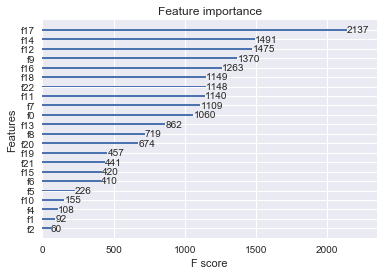

In [216]:
xgb.plot_importance(xgb_model)

In [194]:
cols[9]

'dist'

In [217]:
dftest_part1 = dftest[dftest['count_q']>1]

In [218]:
dftest_part1['prediction'] = xgb_model.predict(dtest)

#### Примеры 

In [ ]:
dftest_part1[(dftest_part1.prediction>0.5)].paragraph.values[56]

In [ ]:
dftest_part1[(dftest_part1.prediction>0.5)].question.values[56]

In [ ]:
dftest_part1[(dftest_part1.prediction<=0.5)].paragraph.values[40]

In [ ]:
dftest_part1[(dftest_part1.prediction<=0.5)].question.values[40]

#### Статистика 

In [149]:
dftest.shape

(74290, 62)

In [150]:
dftest_part1[(dftest_part1.prediction>=0.5)].shape

(3718, 62)

In [151]:
dftest_part1[(dftest_part1.prediction<0.5)].shape

(31469, 62)

In [135]:
ids=dftest_part1[(dftest_part1.prediction>0.5)].question_id.unique()

In [138]:
ids2=[i for i in dftest_part1.question_id.unique() if (i not in ids)]

In [139]:
len(ids2)

687

In [ ]:
dftest_part1[dftest_part1.question_id==ids2[0]].question.values[0]

### Часть 2

In [245]:
cols = ['len_inr',
        'len_name', 
        'len_verb', 
        'len_latn', 
        'len_num', 
        'len_adj', 
        'len_noun',
        'score',
        #'best_score',
        'frequency', 
        'w2v_question', 
        'len_paragraph', 
        'len_question',
        'len_intersection',
        'len_intersection_rate',
        #'max_pred',
        'score1', 
        #'count_p',
        'cosine_distance',
        #'best_score1'
        'red_ratio',
        'w2v_red'
        ]
y = dftrain['target']
#train=train[features]

In [246]:
Xtr, Xv, ytr, yv = train_test_split(dftrain[cols].values, y, test_size=0.2)

In [247]:
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(dftest[dftest['count_q']==1][cols].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

params ={
        'eta':0.03,
        'n_estimators': 3000,
        'max_depth': 3,
        'objective': 'binary:logistic',
        'eval_metric': 'auc'
        }

In [248]:
xgb_model = xgb.train(params = params, dtrain = dtrain, evals=watchlist, num_boost_round = params['n_estimators'], verbose_eval=100, early_stopping_rounds=500)

[0]	train-auc:0.981753	valid-auc:0.980465
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 500 rounds.
[100]	train-auc:0.994265	valid-auc:0.99389
[200]	train-auc:0.995173	valid-auc:0.99482
[300]	train-auc:0.995583	valid-auc:0.995234
[400]	train-auc:0.995805	valid-auc:0.995384
[500]	train-auc:0.995961	valid-auc:0.995473
[600]	train-auc:0.996072	valid-auc:0.995527
[700]	train-auc:0.996176	valid-auc:0.995573
[800]	train-auc:0.996272	valid-auc:0.995608
[900]	train-auc:0.996357	valid-auc:0.995652
[1000]	train-auc:0.99644	valid-auc:0.995689
[1100]	train-auc:0.996512	valid-auc:0.995715
[1200]	train-auc:0.996601	valid-auc:0.995745
[1300]	train-auc:0.996692	valid-auc:0.995773
[1400]	train-auc:0.996771	valid-auc:0.995789
[1500]	train-auc:0.996842	valid-auc:0.995809
[1600]	train-auc:0.996919	valid-auc:0.995833
[1700]	train-auc:0.996992	valid-auc:0.995855
[1800]	train-auc:0.99706	valid-auc:0.995862
[1900]	train-auc:

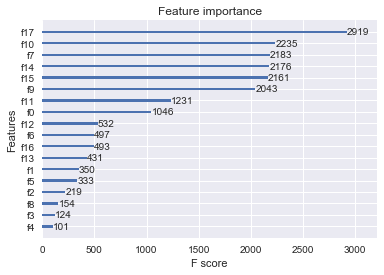

In [249]:
xgb.plot_importance(xgb_model)

In [250]:
cols[15]

'cosine_distance'

In [251]:
dftest_part2 = dftest[dftest['count_q']==1]

In [252]:
dftest_part2['prediction'] = xgb_model.predict(dtest)

####  Примеры

In [256]:
dftest_part2[(dftest_part2.prediction>0.5)].question.values[6]

'Как термин, используемый июпак для идентификации широкого спектра?'

In [254]:
dftest_part2[(dftest_part2.prediction>0.5)].paragraph.values[1]

'Против социального эмпиризма (позитивизма) первым выступил ещё Гегель, который противостоял как эмпиризму, так и детерминизму, который считал слишком механистическим:169. Ранние представители герменевтики, такие, как Вильгельм Дильтей, впервые ввели различие между естественными и социальными науками. Различные неокантианцы, феноменологи и учёные гуманитарных направлений развивали теоретические обоснования отличия мира природы от социальной реальности, увязывая это различие с такими сложными аспектами человеческого общества, как культура и бытие. Методология Карла Маркса была прежде всего основана на гегелевской диалектике, но также противостояла позитивизму, выводя на первый план критический анализ явлений:202-203.'

#### Статистика 

In [255]:
dftest_part2[(dftest_part2.prediction<=0.5)].shape

(20220, 62)

In [244]:
dftest_part2[(dftest_part2.prediction>0.5)].shape

(13992, 62)

In [162]:
dftest_part1.rename({'prediction1':'prediction'}, inplace=True)
#dftest_part2.rename({'prediction1':'prediction'})

In [179]:
dftest_part1.head(2)

,Unnamed: 0,Unnamed: 0.1,paragraph,paragraph_id,question,question_id,target,sent_paragraph,num_sent_paragraph,tokens_sent_paragraph,...,max_pred,qw_num,verb_num,adj_num,noun_num,pca1,pca2,red_ratio,w2v_red,prediction
0,0,0,"Передний мозг сильно развит, это самая большая...",1361,В какой мифологии два ворона Хугин и Мунин шеп...,6463,-1.0,"['Передний мозг сильно развит, это самая больш...","[[], [], [], [], [], [], [], [], []]","[['передний', 'мозг', 'сильно', 'развитый', 'с...",...,0.999496,0.1,0.1,0.0,0.8,-1.550609,-0.316235,1.0,0.0,0.000037
1,1,1,Различные виды ткачиковых в Африке и Центральн...,974,В какой мифологии два ворона Хугин и Мунин шеп...,6463,-1.0,['Различные виды ткачиковых в Африке и Централ...,"[[], [], [], [], []]","[['различный', 'вид', 'ткачиков', 'африка', 'ц...",...,0.999803,0.1,0.1,0.0,0.8,-1.550609,-0.316235,1.0,0.0,0.000004


In [229]:
dftest_results=pd.concat([dftest_part1, dftest_part2])

In [230]:
dftest_part1[['prediction']].head(2)

,prediction
0,0.000040
1,0.000005


In [231]:
del dftest['prediction']

In [232]:
dftest=dftest.merge(dftest_results[['paragraph_id','question_id','prediction']], how='left', on=['paragraph_id','question_id'])

In [233]:
dftest.shape

(74290, 62)

In [234]:
dftest.prediction.isnull().sum()

0

In [235]:
dftest[['paragraph_id', 'question_id', 'prediction']].to_csv("prediction.csv", index=False)

In [ ]:
#dftest[dftest['count']>1].prediction.value_counts()

In [ ]:
#dftest.columns

In [ ]:
#del dftest['prediction_x']

In [ ]:
#del dftest['prediction_y']

In [ ]:
#del dftest['prediction']

In [114]:
dftest.to_csv('./testTFIDF.csv')
dftrain.to_csv('./trainTFIDF.csv')